In [ ]:
!pip install yfinance prophet

In [3]:
from main import get_pair_tickers
import pandas as pd
usdt_tickers = get_pair_tickers()
data = pd.read_pickle(f'usdt_data/{usdt_tickers[1]}.pickle').astype(float)
data = data[['open','high','low','close','volume','trades']].dropna()

In [14]:
btcdata = pd.read_pickle(f'usdt_data/BTCUSDT.pickle').astype(float)
btcdata = btcdata[['open','high','low','close','volume','trades']].dropna()

In [6]:
from prophet import Prophet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
train_end_date = data.index[int(len(data)*.75)]

In [ ]:
#essayer avec toutes les features ou k-acp

In [47]:
df_train = pd.DataFrame()
df_train['ds']=data.index[data.index<train_end_date].copy()
df_train['y']=data['close'][data.index<train_end_date].copy().reset_index(drop=True)
df_train['MA'] = df_train['y'].rolling(window=3).mean().copy().reset_index(drop=True)
df_train = df_train.iloc[2:,:]

df_test= pd.DataFrame()
df_test['ds']=data.index[data.index>train_end_date].copy()
df_test['y']=data['close'][data.index>train_end_date].copy().reset_index(drop=True)
df_test['MA'] = df_test['y'].rolling(window=3).mean().copy().reset_index(drop=True)
df_test = df_test.iloc[2:,:]

In [48]:
model_baseline = Prophet()
model_baseline.fit(df_train)

22:32:39 - cmdstanpy - INFO - Chain [1] start processing
22:33:26 - cmdstanpy - INFO - Chain [1] done processing


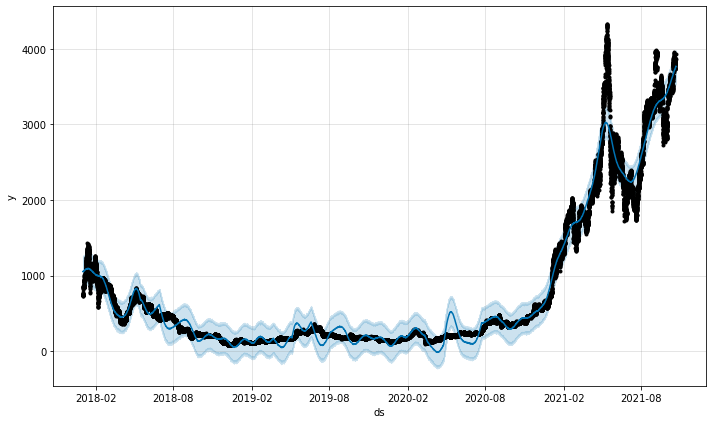

In [49]:
future_baseline = model_baseline.make_future_dataframe(periods=24, freq='H')
forecast_baseline = model_baseline.predict(future_baseline)
model_baseline.plot(forecast_baseline);

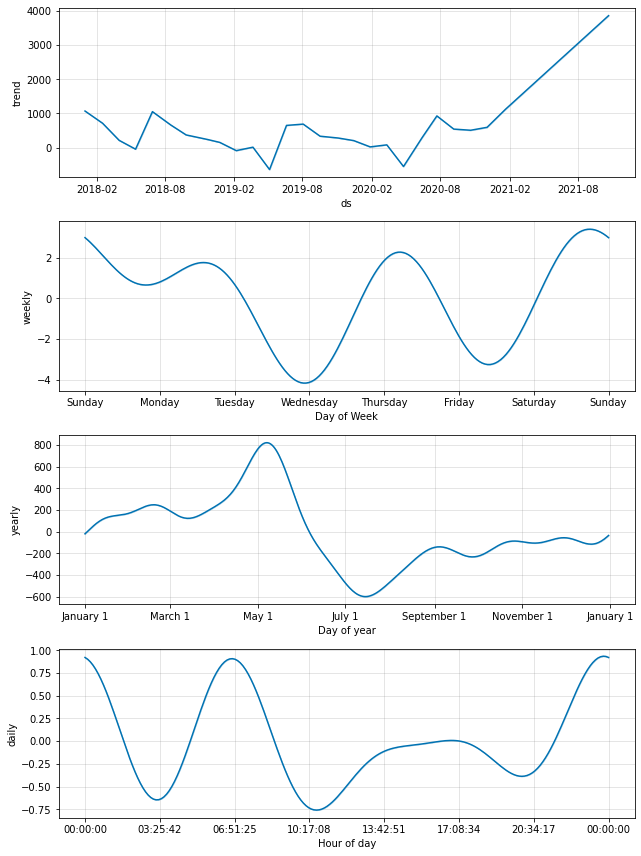

In [50]:
model_baseline.plot_components(forecast_baseline);

In [51]:
performance_baseline = pd.merge(df_test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 427.760679633253
The MAPE for the baseline model is 0.10192407119149204


In [70]:
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, changepoint_prior_scale=0.01, seasonality_prior_scale=10)
model_season.fit(df_train)

22:48:07 - cmdstanpy - INFO - Chain [1] start processing
22:48:54 - cmdstanpy - INFO - Chain [1] done processing


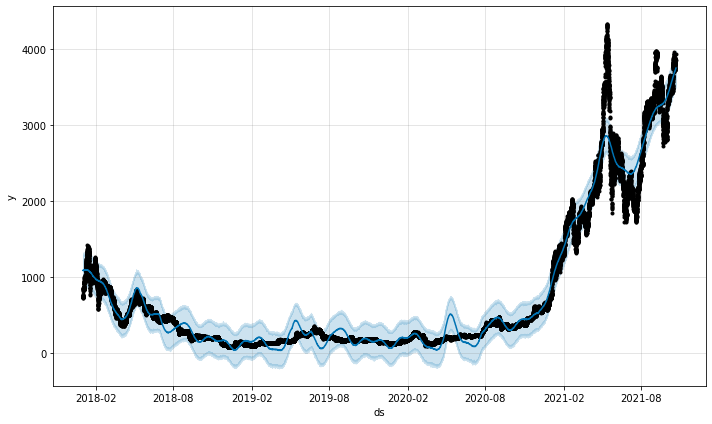

In [71]:
future_season = model_season.make_future_dataframe(periods=24, freq='H')
forecast_season = model_season.predict(future_season)
model_season.plot(forecast_season);

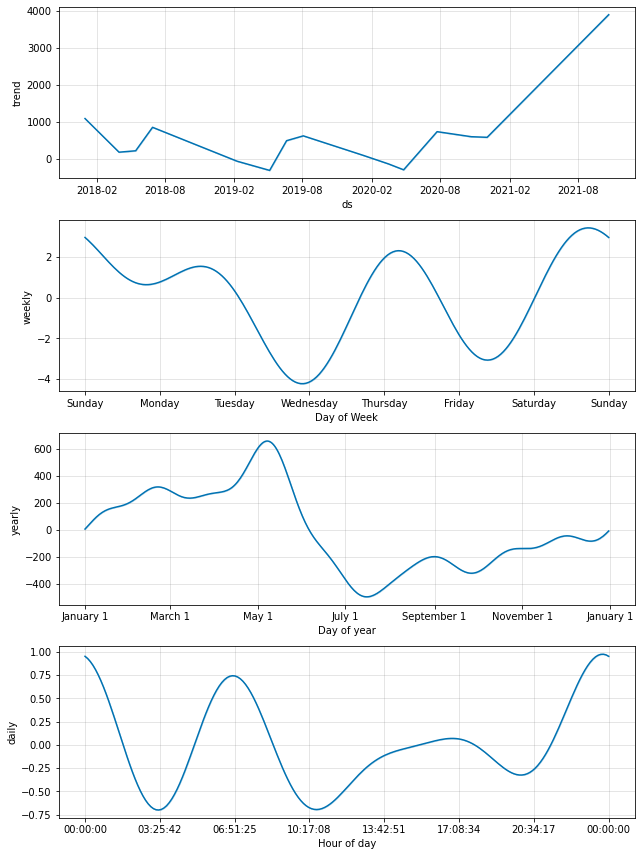

In [54]:
model_season.plot_components(forecast_season);

In [56]:
performance_season = pd.merge(df_test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 445.5954070525415
The MAPE for the seasonality model is 0.10617973915462692


In [61]:
# Add seasonality 
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
# Add regressor
model_multivariate.add_regressor('MA', standardize=False)
# Fit the model on the training dataset
model_multivariate.fit(df_train)

22:40:48 - cmdstanpy - INFO - Chain [1] start processing
22:41:14 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=16)
# Append the regressor values
future_multivariate = pd.merge(future_multivariate, df_train[['ds', 'MA']], on='ds', how='inner')
# Fill the missing values with the previous value
future_multivariate.tail(10)

,ds,MA
33192,2021-10-20 03:00:00,3849.943333
33193,2021-10-20 04:00:00,3849.566667
33194,2021-10-20 05:00:00,3847.600000
33195,2021-10-20 06:00:00,3845.526667
33196,2021-10-20 07:00:00,3845.840000
33197,2021-10-20 08:00:00,3848.970000
33198,2021-10-20 09:00:00,3859.160000
33199,2021-10-20 10:00:00,3857.556667
33200,2021-10-20 11:00:00,3861.020000
33201,2021-10-20 12:00:00,3882.656667


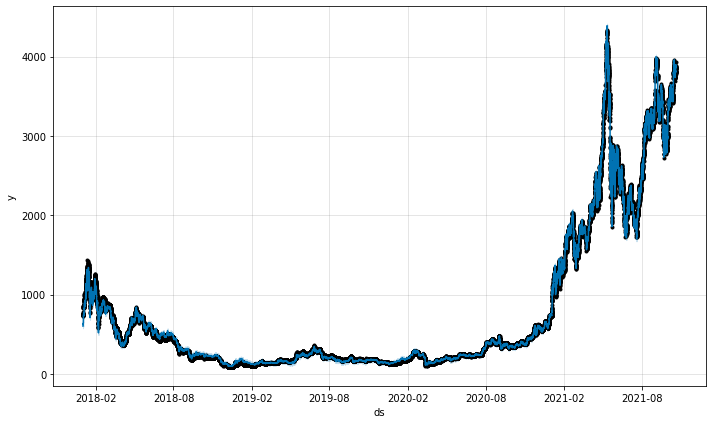

In [67]:
forecast_multivariate = model_multivariate.predict(future_multivariate)
model_multivariate.plot(forecast_multivariate);

In [68]:
forecast_multivariate

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,MA,MA_lower,MA_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01 02:00:00,-170.510805,574.388285,627.534908,-170.510805,-170.510805,752.452125,752.452125,752.452125,772.329837,772.329837,772.329837,-0.633126,-0.633126,-0.633126,752.452125,752.452125,752.452125,0.135568,0.135568,0.135568,20.375270,20.375270,20.375270,0.0,0.0,0.0,601.819032
1,2018-01-01 03:00:00,-170.438392,576.525579,632.274983,-170.438392,-170.438392,754.838175,754.838175,754.838175,774.897035,774.897035,774.897035,-0.520131,-0.520131,-0.520131,754.838175,754.838175,754.838175,0.157069,0.157069,0.157069,20.421921,20.421921,20.421921,0.0,0.0,0.0,604.458643
2,2018-01-01 04:00:00,-170.365979,586.793803,641.067750,-170.365979,-170.365979,764.150015,764.150015,764.150015,784.696855,784.696855,784.696855,-0.097455,-0.097455,-0.097455,764.150015,764.150015,764.150015,0.175823,0.175823,0.175823,20.468473,20.468473,20.468473,0.0,0.0,0.0,614.330876
3,2018-01-01 05:00:00,-170.293566,599.020234,651.460096,-170.293566,-170.293566,772.799448,772.799448,772.799448,793.807239,793.807239,793.807239,0.301149,0.301149,0.301149,772.799448,772.799448,772.799448,0.191719,0.191719,0.191719,20.514923,20.514923,20.514923,0.0,0.0,0.0,623.513673
4,2018-01-01 06:00:00,-170.221153,608.057084,660.722257,-170.221153,-170.221153,782.399140,782.399140,782.399140,803.540061,803.540061,803.540061,0.374961,0.374961,0.374961,782.399140,782.399140,782.399140,0.204689,0.204689,0.204689,20.561271,20.561271,20.561271,0.0,0.0,0.0,633.318908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33197,2021-10-20 08:00:00,-141.075655,3832.591749,3888.378427,-141.075655,-141.075655,4004.580007,4004.580007,4004.580007,4001.514639,4001.514639,4001.514639,-0.267572,-0.267572,-0.267572,4004.580007,4004.580007,4004.580007,0.413389,0.413389,0.413389,-3.211185,-3.211185,-3.211185,0.0,0.0,0.0,3860.438984
33198,2021-10-20 09:00:00,-141.089714,3843.951124,3897.261648,-141.089714,-141.089714,4015.181978,4015.181978,4015.181978,4011.955594,4011.955594,4011.955594,-0.429562,-0.429562,-0.429562,4015.181978,4015.181978,4015.181978,0.408876,0.408876,0.408876,-3.205698,-3.205698,-3.205698,0.0,0.0,0.0,3870.865880
33199,2021-10-20 10:00:00,-141.103774,3842.379906,3897.169490,-141.103774,-141.103774,4013.513824,4013.513824,4013.513824,4010.428965,4010.428965,4010.428965,-0.285279,-0.285279,-0.285279,4013.513824,4013.513824,4013.513824,0.400646,0.400646,0.400646,-3.200225,-3.200225,-3.200225,0.0,0.0,0.0,3869.325191
33200,2021-10-20 11:00:00,-141.117834,3846.914109,3901.143561,-141.117834,-141.117834,4017.117176,4017.117176,4017.117176,4014.328247,4014.328247,4014.328247,0.017189,0.017189,0.017189,4017.117176,4017.117176,4017.117176,0.388649,0.388649,0.388649,-3.194767,-3.194767,-3.194767,0.0,0.0,0.0,3873.210413


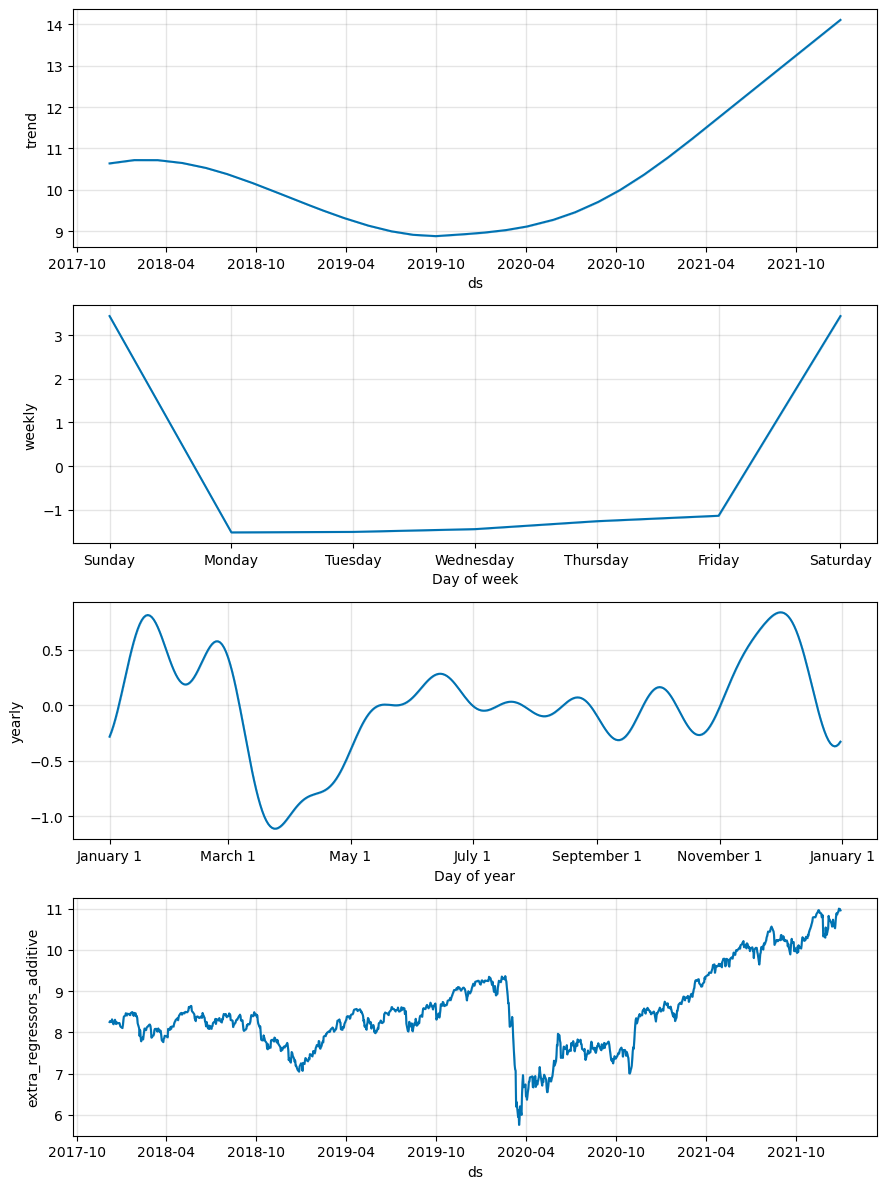

In [20]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [21]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')
# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 0.7761350566435
The MAPE for the multivariate model is 0.03200079048726369


In [22]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,    
})
# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,    
})
# Combine all events
events = pd.concat((COVID, superbowl))
# Take a look at the events data
events


,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2020-02-02,-7,1
1,superbowl,2021-02-07,-7,1


In [23]:
# Add holidays
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=events)
# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='FR')
# Add regressor
model_holiday.add_regressor('CAC 40', standardize=False)
# Fit the model on the training dataset
model_holiday.fit(train)
# All the holidays and events
model_holiday.train_holiday_names

10:30:03 - cmdstanpy - INFO - Chain [1] start processing
10:30:03 - cmdstanpy - INFO - Chain [1] done processing


0                  COVID
1              superbowl
2           Jour de l'an
3        Fête du Travail
4         Armistice 1945
5         Fête nationale
6         Armistice 1918
7        Lundi de Pâques
8     Lundi de Pentecôte
9              Ascension
10            Assomption
11             Toussaint
12                  Noël
dtype: object

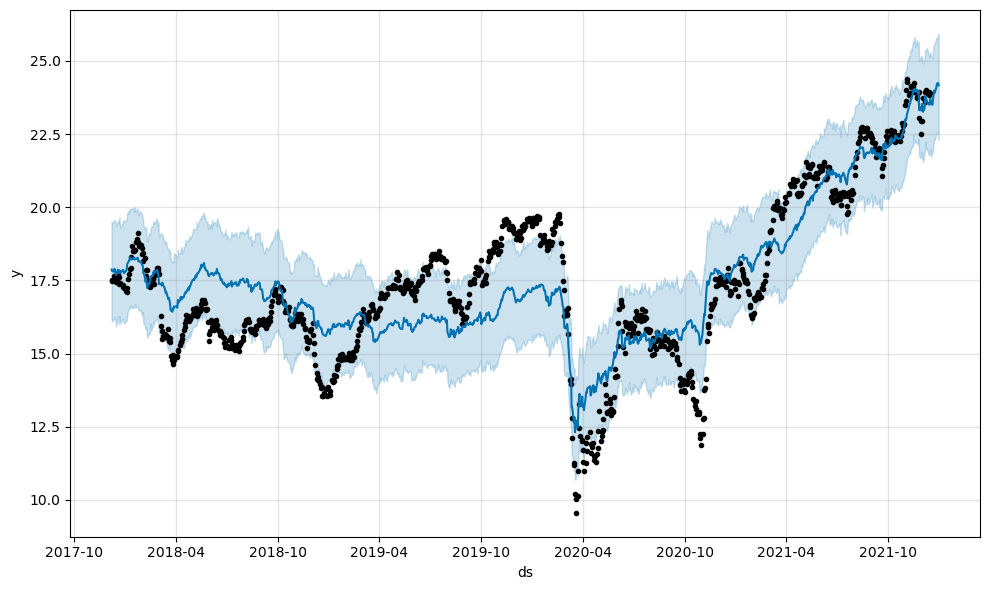

In [24]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=16)
# Append the regressor values
future_holiday = pd.merge(future_holiday, data[['ds', 'CAC 40']], on='ds', how='inner')
# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')
# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)
# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

In [25]:
# Merge actual and predicted values
performance_holiday = pd.merge(test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')
# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

The MAE for the holiday/event model is 0.25485086014350483
The MAPE for the holiday/event model is 0.010519500727842683


In [26]:
# Check correlation
data.corrwith(data["y"])

y         1.000000
CAC 40    0.927506
dtype: float64

In [29]:
forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

,ds,yhat,yhat_lower,yhat_upper
1038,2021-12-29,24.178302,22.514225,25.786769
1039,2021-12-30,24.248084,22.573966,25.882765
1040,2021-12-31,24.166966,22.310172,25.924236


In [30]:
getNbOfDay = 3
forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(getNbOfDay)

,ds,yhat,yhat_lower,yhat_upper
1038,2021-12-29,24.178302,22.514225,25.786769
1039,2021-12-30,24.248084,22.573966,25.882765
1040,2021-12-31,24.166966,22.310172,25.924236
